### Importing the libraries

In [0]:
import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', -1)

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from nltk.stem import PorterStemmer
ps = PorterStemmer()

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
import warnings
warnings.filterwarnings("ignore")

#### Upload the files

In [0]:
train = pd.read_csv('train.csv',engine = 'python')
test = pd.read_csv('test.csv',engine= 'python')

train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True) # donald trump

In [0]:
# removing all the rows of Xtest that contains donald trump

test = test[test['Target'] != 'Donald Trump']
test.shape

(1249, 5)

### Visualization of data

In [0]:
train.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,Ok armchair feminists got their panties wet. If you're a social justice warrior go out and do something. Get off tumblr. #SemST,Feminist Movement,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
1,Pop quiz: Whats the greatest fear of the oppressor? #humanrights #BlackLivesMatter #SemST,Feminist Movement,NONE,2. The tweet does NOT expresses opinion about the target but it HAS opinion about something or someone other than the target.,neg
2,You will never control yourself until you confront self as a problem.-Pastor Merritt #Christian #Church #SemST,Atheism,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
3,@tedcruz @IamTheWindowMan GET OUT OF MY STATE YOU BUM! #UniteBlue #SemST,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about the target but it HAS opinion about something or someone other than the target.,neg
4,@TX_1 @politicalmath Then you know how slippery snakes slither over shards of glass! #SemST,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about the target but it HAS opinion about something or someone other than the target.,neg


### Cleaning the data

In [0]:
Xtrain = train[['Tweet','Target']]
ytrain = train['Stance']

Xtest = test[['Tweet','Target']]
ytest = test['Stance']



In [0]:
print('Traing data features shape ',Xtrain.shape)
print('Test data features shape',Xtest.shape)

print('Train data target shape ',ytrain.shape)
print('Test data target shape ',ytest.shape)

Traing data features shape  (2914, 2)
Test data features shape (1249, 2)
Train data target shape  (2914,)
Test data target shape  (1249,)


In [0]:
def category_encoder(data):
    samp = data['Target']
    samp[samp == 'Hillary Clinton'] = 'hillary'
    samp[samp == 'Feminist Movement'] = 'feminism'
    samp[samp == 'Legalization of Abortion'] = 'abortion'
    samp[samp == 'Atheism'] = 'atheism'
    samp[samp == 'Climate Change is a Real Concern'] = 'climate'

    dummy = pd.get_dummies(data['Target'])
    data = pd.concat([data,dummy],axis = 1)
    del data['Target']

    return data

def label_encoder(samp):
    samp[samp == 'AGAINST'] = 0
    samp[samp == 'FAVOR'] = 1
    samp[samp == 'NONE'] = 2

    return samp



In [0]:
def preprocess(text):
  mod_words = []
  words = text.split()
  for word in words:
      if word[0] == '@':
          continue
      if word[0] == '#':
          word = word[1:]

      word = word.lower()
      symbols = ['.',',','?','!']
      if len(word) == 0:
          continue

      if word[-1] in symbols:
          word = word[:-1]
      if len(word) > 2 and word not in stop_words and word.isalpha():
        word = lemmatizer.lemmatize(word)
        mod_words.append(word)

  text = ''
  for word in mod_words:
    text = text + ' '+ word
  return text





In [0]:

Xtrain = category_encoder(Xtrain)
Xtest = category_encoder(Xtest)

ytrain = label_encoder(ytrain)
ytest = label_encoder(ytest)

ytrain = ytrain.astype('int')
ytest = ytest.astype('int')

In [0]:
print('Traing data features shape ',Xtrain.shape)
print('Test data features shape',Xtest.shape)

print('Train data target shape ',ytrain.shape)
print('Test data target shape ',ytest.shape)

Traing data features shape  (2914, 6)
Test data features shape (1249, 6)
Train data target shape  (2914,)
Test data target shape  (1249,)


In [0]:
Xtrain['Tweet'] = Xtrain['Tweet'].apply(preprocess)
Xtest['Tweet'] = Xtest['Tweet'].apply(preprocess)


#### After Pre processing :

In [0]:

print('---- Train Data ----')
print(Xtrain.head())
print('---- Test Data ----')
print(Xtest.head())

---- Train Data ----
                                                                               Tweet  ...  hillary
0   brain heart unique dna alive human please kill semst                              ...  0      
1   one basic cause abuse general men give damn semst                                 ...  0      
2   even clifford virginia stophidingit semst                                         ...  0      
3   faithful god pray may learn trust uncertainty mystery walking water toward semst  ...  0      
4   crucifixion christ lead world salvation thing started darkages skepticism semst   ...  0      

[5 rows x 6 columns]
---- Test Data ----
                                                                                 Tweet  ...  hillary
0   howtospotafeminist sexually unattractive even world rapist would always safe semst  ...  0      
3   money buy libs including semst                                                      ...  1      
5   woman want bear child okay semst    

### 3. Model

#### 3.1 Word Embeddings using TF-IDF 

In [0]:
tweet_array = vectorizer.fit_transform(Xtrain['Tweet']).toarray()
rem_data = np.array(Xtrain[['abortion','atheism','climate','feminism','hillary']])
Xtrain = np.hstack((tweet_array,rem_data)) 

tweet_array = vectorizer.transform(Xtest['Tweet']).toarray()
rem_data = np.array(Xtest[['abortion','atheism','climate','feminism','hillary']])
Xtest = np.hstack((tweet_array,rem_data))

print('Training data shape :',Xtrain.shape)
print('Test data shape:',Xtest.shape)

Training data shape : (2914, 6481)
Test data shape: (1249, 6481)


##### pickling the data

In [0]:
import pickle
out = open('Xtrain.pkl','wb')
pickle.dump(Xtrain,out)


out = open('Xtest.pkl','wb')
pickle.dump(Xtest,out)


out = open('Ytrain.pkl','wb')
pickle.dump(ytrain,out)


out = open('ytest.pkl','wb')
pickle.dump(ytest,out)

#### 3.1.1 Logistic Regression with tfidf

In [0]:
logreg = LogisticRegression(penalty = 'l2',solver='liblinear',multi_class='ovr',max_iter=1000)
logistic_classifier = logreg.fit(Xtrain,ytrain)

In [0]:
ypred_train  = logistic_classifier.predict(Xtrain)
ypred_test  = logistic_classifier.predict(Xtest)

print('F1 score for train data :',f1_score(ytrain, ypred_train, average='macro'))
print('F1 score for test data :',f1_score(ytest, ypred_test, average='macro'))

F1 score for train data : 0.7669118963916463
F1 score for test data : 0.5166770898478217


#### Grid Search CV

In [0]:
penalty = ['l1', 'l2']

C = np.logspace(-4, 4, 20)
print(C)
hyperparameters = dict(C=C, penalty=penalty)


[1.00000000e-04 2.63665090e-04 6.95192796e-04 1.83298071e-03
 4.83293024e-03 1.27427499e-02 3.35981829e-02 8.85866790e-02
 2.33572147e-01 6.15848211e-01 1.62377674e+00 4.28133240e+00
 1.12883789e+01 2.97635144e+01 7.84759970e+01 2.06913808e+02
 5.45559478e+02 1.43844989e+03 3.79269019e+03 1.00000000e+04]


In [0]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(LogisticRegression(), hyperparameters, cv=5, verbose=0)
best_model = clf.fit(Xtrain, ytrain)

In [0]:
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 11.288378916846883


In [0]:
ypred_train  = best_model.predict(Xtrain)
ypred_test  = best_model.predict(Xtest)

print('F1 score for train data :',f1_score(ytrain, ypred_train, average='macro'))
print('F1 score for test data :',f1_score(ytest, ypred_test, average='macro'))

F1 score for train data : 0.9946097913277715
F1 score for test data : 0.5481994921594852


#### 3.1.2 Visualization of results

##### 3.1.3.1  Accuracies

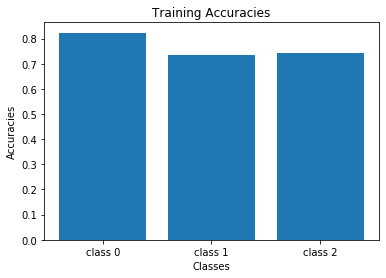

In [0]:
cls = ['class 0','class 1','class 2']
train_acc = f1_score(ytrain, ypred_train, average=None)
plt.bar(cls,train_acc)
plt.title('Training Accuracies')
plt.xlabel('Classes')
plt.ylabel('Accuracies')
plt.show()

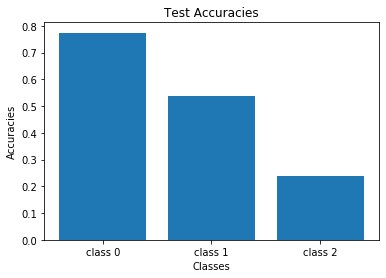

In [0]:

test_acc = f1_score(ytest, ypred_test, average=None)
plt.bar(cls,test_acc)
plt.title('Test Accuracies')
plt.xlabel('Classes')
plt.ylabel('Accuracies')
plt.show()

##### 3.1.3.2 Classification matrix

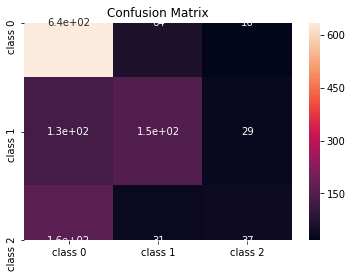

In [0]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ytest,ypred_test)
df_cm = pd.DataFrame(cm,index = [i for i in cls],columns = [i for i in cls])
plt.figure()
sns.heatmap(df_cm,annot = True)
plt.title('Confusion Matrix')
plt.show()

##### 3.1.3.3 ROC Curve

In [0]:
pip install scikit-plot

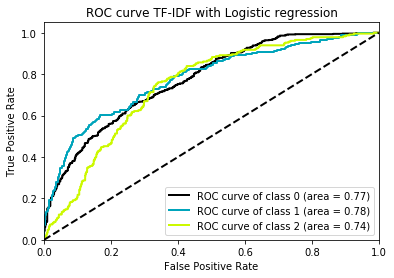

In [0]:
import scikitplot as skp

prob = logistic_classifier.predict_proba(Xtest)
skp.metrics.plot_roc_curve(ytest,prob,title = 'ROC curve TF-IDF with Logistic regression',curves = 'each_class')